The code that has been used to augment and train the model for the ships has been taken from - 
https://www.kaggle.com/code/imvivekthakur/2-shipsdetection-satelliteimagery

# Detection using Faster R-CNN

This notebook contains a process of creating an end to end Faster R-CNN model using tensorflow. First features are extracted from the images using a CNN model and then passed through a Region Proposal Network(RPN). All due credit for the algorithm goes to the authors of the paper, *Faster R-CNN: Towards Real-Time Object
Detection with Region Proposal Networks*.

It is divided up into 2 notebooks:
1. Data visualisation
2. Creating a model for classifying the ROIs into the 2 classes, *ship* and *no-ship* .
<!-- 2. [Part 2]: Using Selective Search for obtaining ROIs and testing of model on geospatial data. -->

# Importing libraries

The necessary libraries required for implementing the Faster R-CNN model are imported in the code block below.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

# Utility functions

* show_final_history - For plotting the loss and accuracy of the training and validation datasets
* plot_confusion_matrix - For plotting the percentage of true positives per class for a better feel of how the model predicted the data

In [3]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [4]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

This cell maps 0,1 to no-ship and ship labels respectively

In [5]:
datasets = ['../input/satellite-imagery-of-ships']

class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [6]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            label = class_name_labels[folder]

            for file in tqdm(os.listdir(os.path.join(dataset,folder))):

                img_path = os.path.join(dataset,folder,file)

                img = cv2.imread(img_path)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (48,48))

                images.append(img)
                labels.append(label)
                pass
            pass

        images = np.array(images,dtype=np.float32)/255.0
        labels = np.array(labels,dtype=np.float32)
        pass

    return (images, labels)
    pass

In [7]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████| 1000/1000 [00:00<00:00, 3320.20it/s]


((4000, 48, 48, 3), (4000,))

The counts and class distributions are visualised using bar and pie graphs respectively

In [8]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
no-ship,3000
ship,1000


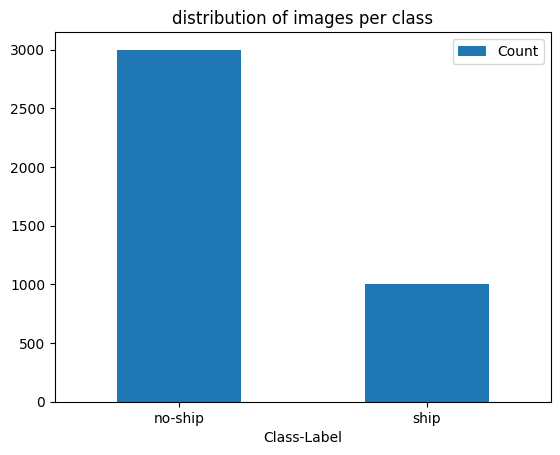

In [9]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

As it can be seen that the data is skewed towards the *no-ship* class with 75% of images belonging to that very specific class.

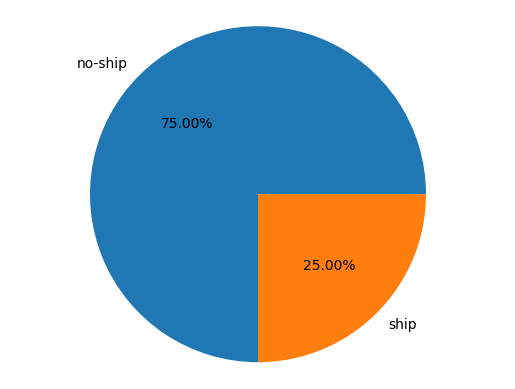

In [10]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

# Augmenting Images of Minority Class

The images present in the *ship* class are augmented and then stored in the dataset, so that there is an equal representation of the classes. The current ratio of classes is 1:3, meaning that for every image present in the *ship* class there are 3 images present in the *no-ship* class. This will be countered by producing 2 augmented images per original image of the *ship* class. This will make the dataset balanced.

If augmentation of dataset is required then set AUGMENTATION to *True*. This will balance the dataset via augmentation of minority classes. To train via class weights, then set AUGMENTATION to *False*.

In [11]:
AUGMENTATION = True

In [12]:
def augment_add(images, seq, labels):

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            image_aug_1 = seq.augment_image(image=img)
            image_aug_2 = seq.augment_image(image=img)
            augmented_images.append(image_aug_1)
            augmented_images.append(image_aug_2)
            augmented_labels.append(labels[idx])
            augmented_labels.append(labels[idx])
        pass

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)
    pass

In [13]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0,0.1)),
    iaa.LinearContrast((0.75,1.5)),
    iaa.Multiply((0.8,1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x':(0.8,1.2), "y":(0.8,1.2)},
        translate_percent={"x":(-0.2,0.2),"y":(-0.2,0.2)},
        rotate=(-25,25),
        shear=(-8,8)
    )
], random_order=True)

In [14]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

4000it [00:04, 825.00it/s]  


In [15]:
images.shape, labels.shape

((6000, 48, 48, 3), (6000,))

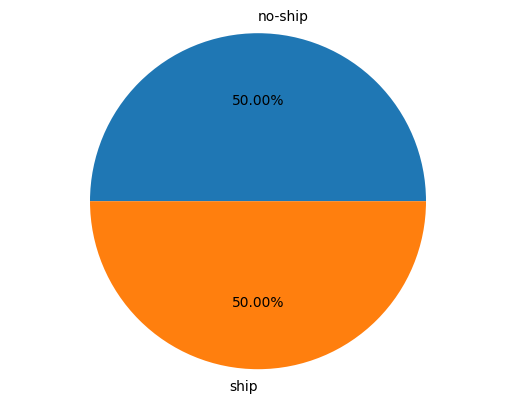

In [16]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

# One Hot Encoding Variables

The labels numpy array is one hot encoded using *to_categorical* from keras. This removes any uncessary bias in the dataset, by keeping the class at equal footing, with respect to labels.

In [17]:
labels = to_categorical(labels)

# Training, Validation and Testing

Instead of using *train_test_split* the images and labels arrays are randomly shuffled using the same seed value set at *42*. This allows the images and their corresponding labels to remain linked even after shuffling.

This method allows the user to make all 3 datasets. The training and validation dataset is used for training the model while the testing dataset is used for testing the model on unseen data. Unseen data is used for simulating real-world prediction, as the model has not seen this data before. It allows the developers to see how robust the model is.

In [18]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

## Spliting of data

* 70% - Training
* 20% - Validation
* 10% - Testing

In [19]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((4200, 48, 48, 3), (1200, 48, 48, 3), (600, 48, 48, 3))

If AUGMENTATION is set True, then the number of images per class is balanced. If AUGMENTATION is set to False, then compute the class weights given below and accordingly change the fit function of the Keras API when training.

In [20]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

In [21]:
def conv_block(X,k,filters,stage,block,s=2):

    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)

    return X
    pass

In [22]:
def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass

In [23]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [24]:
plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 58, 58, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

In [25]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [27]:
epochs = 50
batch_size = 16

history = model.fit(train_images,train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs]
                   )

Epoch 1/50
260/262 [============================>.] - ETA: 0s - loss: 0.3940 - accuracy: 0.8124
Epoch 1: val_accuracy improved from -inf to 0.92583, saving model to model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


262/262 [==============================] - 12s 14ms/step - loss: 0.3926 - accuracy: 0.8132 - val_loss: 0.2755 - val_accuracy: 0.9258
Epoch 2/50
256/262 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9297
Epoch 2: val_accuracy improved from 0.92583 to 0.93500, saving model to model_weights.h5
262/262 [==============================] - 2s 8ms/step - loss: 0.1756 - accuracy: 0.9299 - val_loss: 0.1545 - val_accuracy: 0.9350
Epoch 3/50
262/262 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9502
Epoch 3: val_accuracy improved from 0.93500 to 0.94583, saving model to model_weights.h5
262/262 [==============================] - 3s 10ms/step - loss: 0.1330 - accuracy: 0.9502 - val_loss: 0.1311 - val_accuracy: 0.9458
Epoch 4/50
259/262 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9642
Epoch 4: val_accuracy improved from 0.94583 to 0.96500, saving model to model_weights.h5
262/262 [==============================] - 3s 10m


Epoch 48: val_accuracy did not improve from 0.99167
262/262 [==============================] - 1s 4ms/step - loss: 0.0164 - accuracy: 0.9972 - val_loss: 0.0319 - val_accuracy: 0.9908


This graph visualises the loss and accuracy 

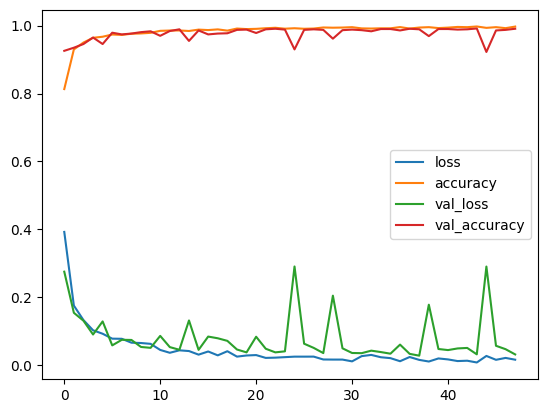

In [28]:
pd.DataFrame(history.history).plot();

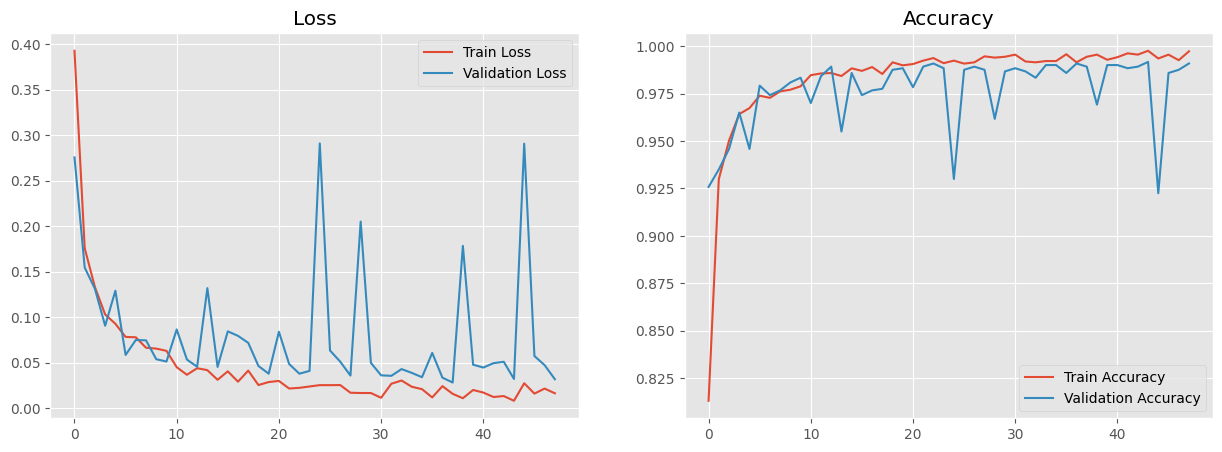

In [29]:
show_final_history(history)

In [30]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred,axis=1)
val_pred.shape

38/38 [==============================] - 0s 3ms/step


(1200,)

<Figure size 640x480 with 0 Axes>

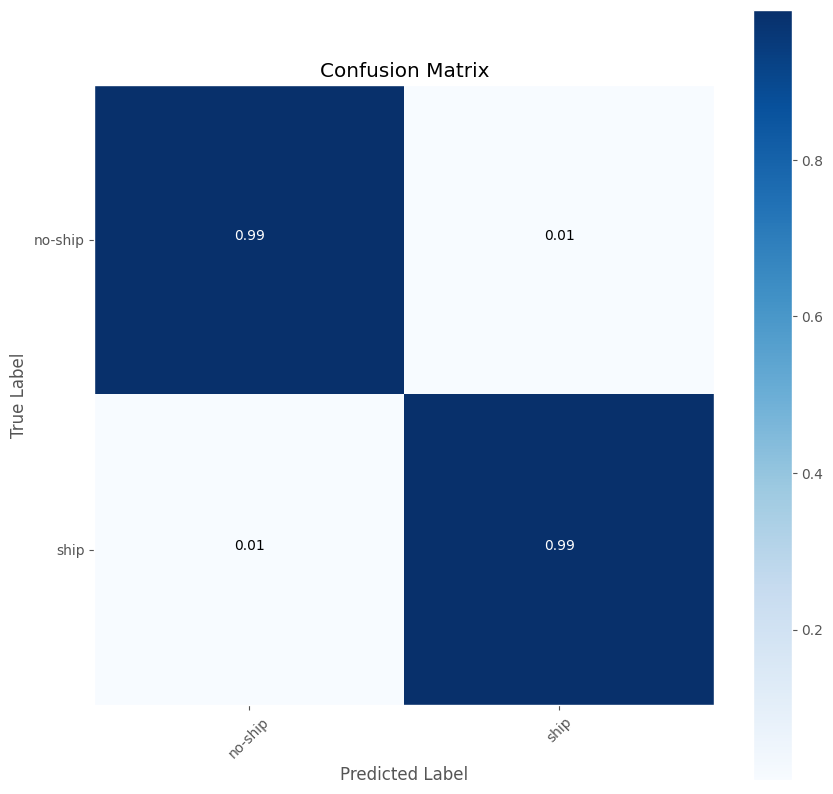

In [31]:
val_actual = np.argmax(val_labels,axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

In [32]:
model.save('ships_detect.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### With Augmentation:

* Precision:
    - *no-ship* : 0.942
    - *ship* : 0.989


* Recall:
    - *no-ship* : 0.99
    - *ship* : 0.94
    
### With class weights

* Precision:
    - *no-ship* : 1.00
    - *ship* : 0.99


* Recall:
    - *no-ship* : 0.99
    - *ship* : 1.00

# Confusion Matrix for Testing Dataset

In [33]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

19/19 [==============================] - 0s 17ms/step


(600,)

<Figure size 640x480 with 0 Axes>

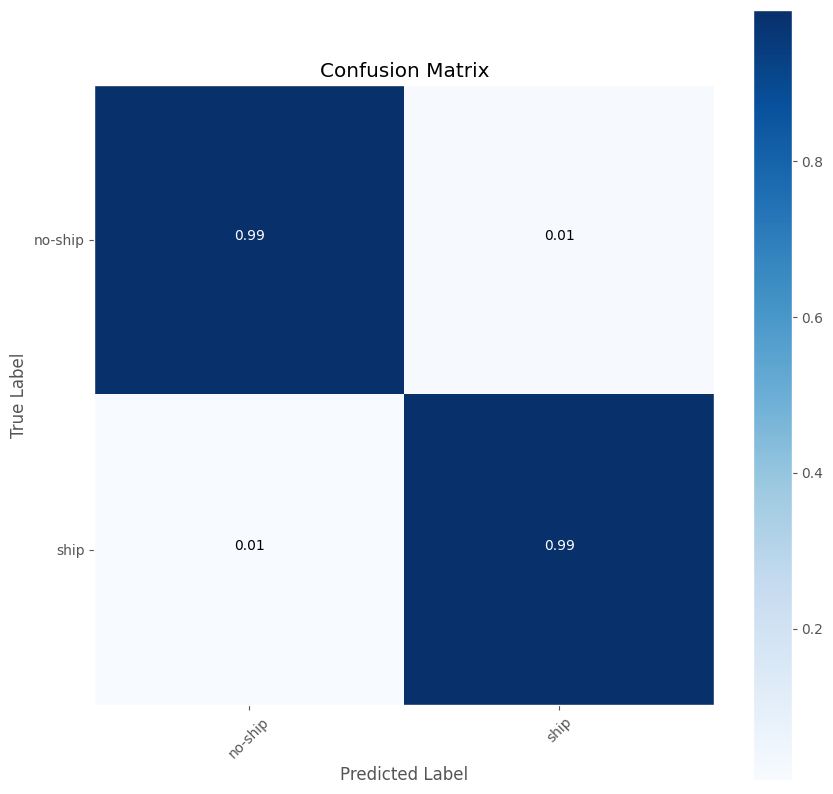

In [34]:
test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

# Checking the model

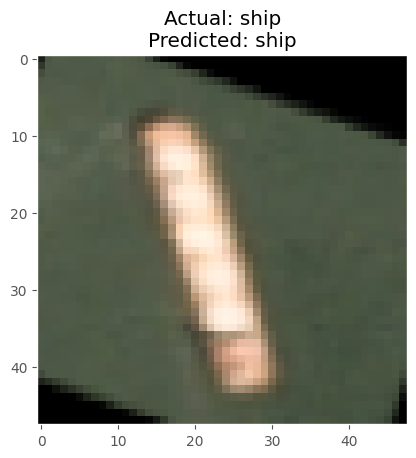

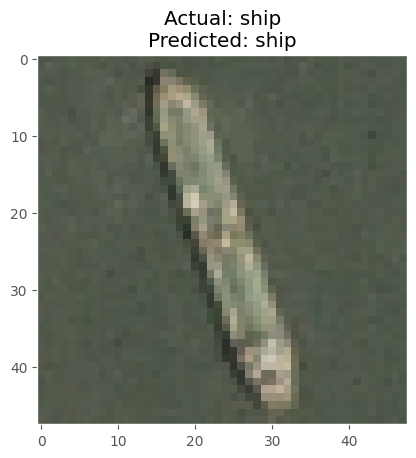

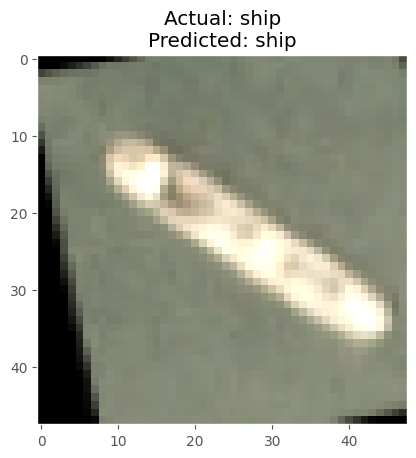

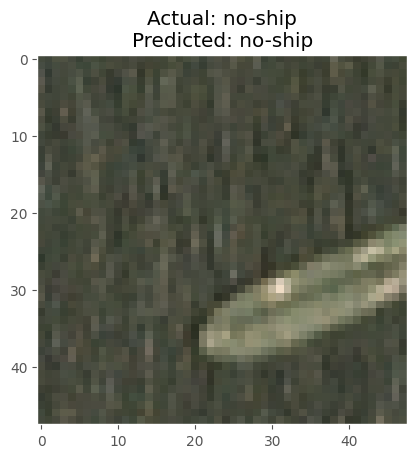

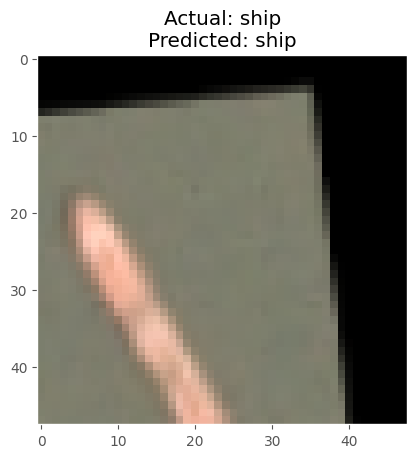

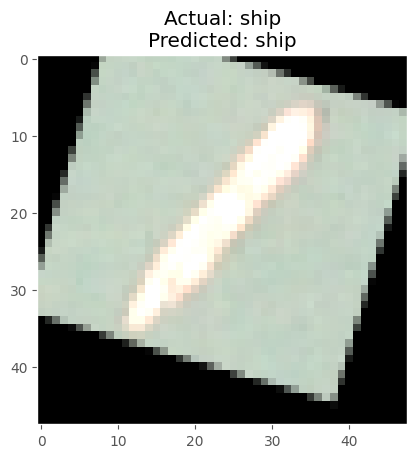

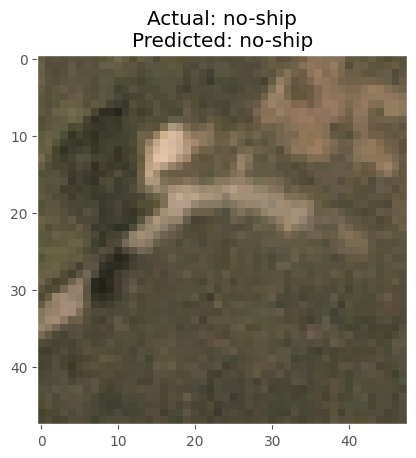

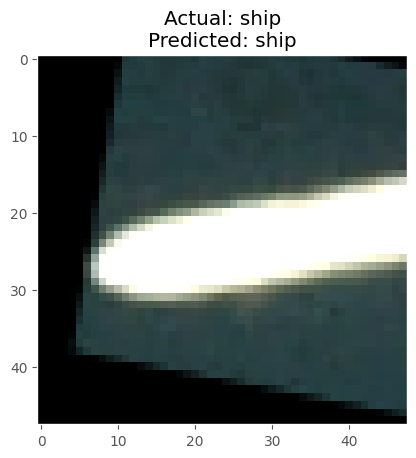

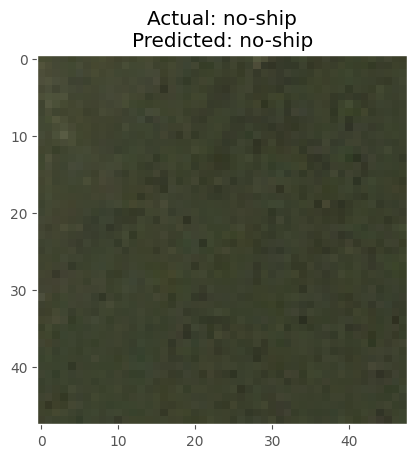

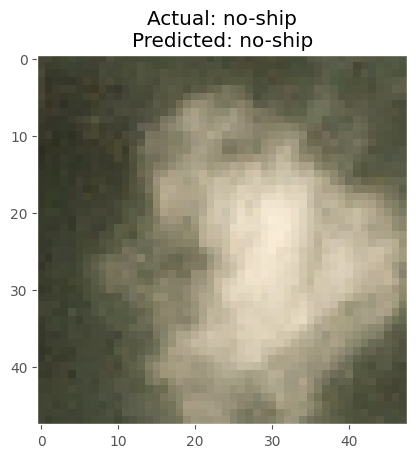

In [35]:
rnd_idx = random.sample(range(0,400),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):

    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass

**Saving the model**

In [36]:
model.save("ship-model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


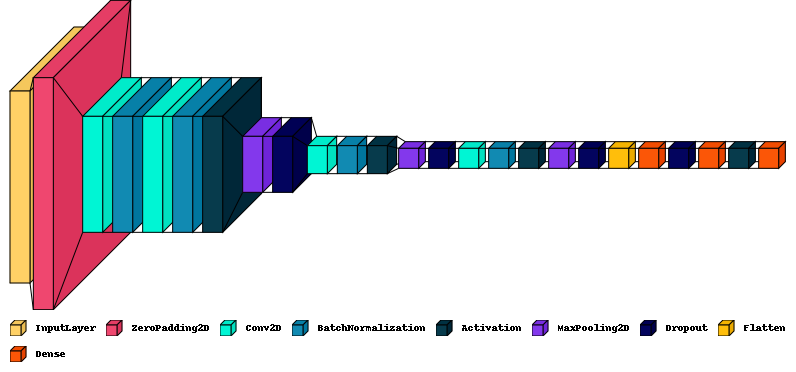

In [39]:
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)#customize the colours
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True,color_map=color_map)

In the following code, an arbitrary value is taken as a scaling factor and must be changed according to the image

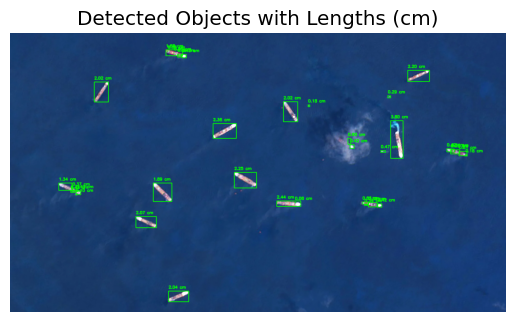

In [61]:
# Read image and preprocess
img_path = "/content/2523523552-1.webp"
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)

edged = cv2.Canny(blur, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

ref_width_cm = 3.8
ref_height_cm = 3.8

if cnts:
    ref_cnt = max(cnts, key=cv2.contourArea)
    ref_x, ref_y, ref_w, ref_h = cv2.boundingRect(ref_cnt)
    ref_pixel_length = max(ref_w, ref_h)
    pixel_to_cm = ref_width_cm / ref_pixel_length
else:
    print("No objects found. Exiting.")
    exit()

# Draw rectangles around objects and display lengths in centimeters
for cnt in cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Calculate length in centimeters
    length_cm = max(w, h) * pixel_to_cm

    # Display length as text
    cv2.putText(image, "{:.2f} cm".format(length_cm), (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert image from BGR to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image using Matplotlib
plt.imshow(image_rgb)
plt.title("Detected Objects with Lengths (cm)")
plt.axis('off')
plt.show()


This code aims to lock onto one of the ships based on the size. All these parameters kust be changed based on the use case 

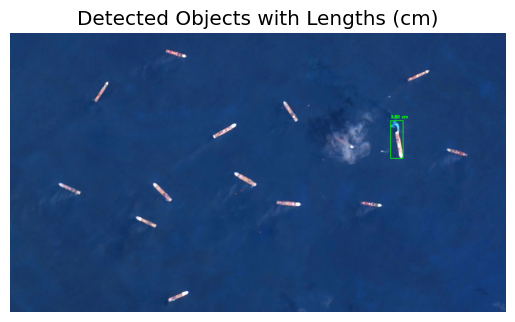

In [40]:
import cv2
import matplotlib.pyplot as plt
import imutils  # Import this library if not already imported

# Read image and preprocess
img_path = "/content/2523523552-1.webp"
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)

edged = cv2.Canny(blur, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

ref_width_cm = 3.8
ref_height_cm = 3.8

# Create a list to store objects greater than 3.3cm
large_objects = []

if cnts:
    ref_cnt = max(cnts, key=cv2.contourArea)
    ref_x, ref_y, ref_w, ref_h = cv2.boundingRect(ref_cnt)
    ref_pixel_length = max(ref_w, ref_h)
    pixel_to_cm = ref_width_cm / ref_pixel_length

    # Draw rectangles around objects and display lengths in centimeters
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        # Calculate length in centimeters
        length_cm = max(w, h) * pixel_to_cm

        # Check if the length exceeds 3.3cm
        if length_cm > 3.3:
            # Save the coordinates of the object
            large_objects.append((x, y, w, h))
            # Draw rectangle and display length as text
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, "{:.2f} cm".format(length_cm), (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Save the portion of the image containing objects larger than 3.3cm
for idx, obj in enumerate(large_objects):
    x, y, w, h = obj
    # Crop the object from the image
    large_object_image = image[y:y+h, x:x+w]
    # Save the cropped object as a separate image file
    cv2.imwrite(f'large_object_{idx}.jpg', large_object_image)

# Convert image from BGR to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image using Matplotlib
plt.imshow(image_rgb)
plt.title("Detected Objects with Lengths (cm)")
plt.axis('off')
plt.show()


The ship that is selected is zoomed into and saved as a new image. This new image is now used for further classification

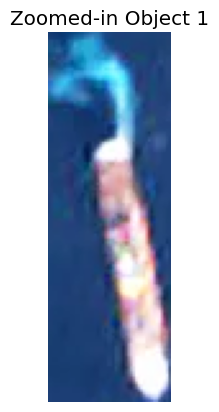

In [41]:
import cv2
import matplotlib.pyplot as plt
import imutils  # Import this library if not already imported

# Read image and preprocess
img_path = "/content/2523523552-1.webp"
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)

edged = cv2.Canny(blur, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

ref_width_cm = 3.8
ref_height_cm = 3.8

# Create a list to store objects greater than 3.3cm
large_objects = []

if cnts:
    ref_cnt = max(cnts, key=cv2.contourArea)
    ref_x, ref_y, ref_w, ref_h = cv2.boundingRect(ref_cnt)
    ref_pixel_length = max(ref_w, ref_h)
    pixel_to_cm = ref_width_cm / ref_pixel_length

    # Draw rectangles around objects and display lengths in centimeters
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        # Calculate length in centimeters
        length_cm = max(w, h) * pixel_to_cm

        # Check if the length exceeds 3.3cm
        if length_cm > 3.3:
            # Save the coordinates of the object
            large_objects.append((x, y, w, h))

# Display only the zoomed-in objects
for idx, obj in enumerate(large_objects):
    x, y, w, h = obj
    # Crop the object from the image
    zoomed_object_image = image[y:y+h, x:x+w]
    # Convert image from BGR to RGB for displaying with Matplotlib
    zoomed_object_rgb = cv2.cvtColor(zoomed_object_image, cv2.COLOR_BGR2RGB)
    # Plot the zoomed-in object using Matplotlib
    plt.imshow(zoomed_object_rgb)
    plt.title(f"Zoomed-in Object {idx+1}")
    plt.axis('off')
    plt.show()


In [42]:
import cv2
import matplotlib.pyplot as plt
import imutils  # Import this library if not already imported

# Read image and preprocess
img_path = "/content/2523523552-1.webp"
image = cv2.imread(img_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)

edged = cv2.Canny(blur, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

# Find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

ref_width_cm = 3.8
ref_height_cm = 3.8

# Create a list to store objects greater than 3.3cm
large_objects = []

if cnts:
    ref_cnt = max(cnts, key=cv2.contourArea)
    ref_x, ref_y, ref_w, ref_h = cv2.boundingRect(ref_cnt)
    ref_pixel_length = max(ref_w, ref_h)
    pixel_to_cm = ref_width_cm / ref_pixel_length

    # Draw rectangles around objects and display lengths in centimeters
    for cnt in cnts:
        x, y, w, h = cv2.boundingRect(cnt)
        # Calculate length in centimeters
        length_cm = max(w, h) * pixel_to_cm

        # Check if the length exceeds 3.3cm
        if length_cm > 3.3:
            # Save the coordinates of the object
            large_objects.append((x, y, w, h))

# Save the first zoomed-in object as "sample.jpeg" file
if large_objects:
    x, y, w, h = large_objects[0]
    # Crop the object from the image
    zoomed_object_image = image[y:y+h, x:x+w]
    # Save the cropped object as "sample.jpeg"
    cv2.imwrite("sample.jpeg", zoomed_object_image)
else:
    print("No objects larger than 3.3cm found.")


In [43]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [54]:
def show_heatmap(model, img_path):
    image = load_img(img_path, target_size=(48, 48))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    i = np.argmax(preds[0])
    label_to_class = {'No Ship': 0,
                      'Ship': 1
                      }

    class_to_label = {v: k for k, v in label_to_class.items()}

    label = class_to_label[i]
    print(f'Predicted class: {label} | Prediction probability: {max(preds[0]) * 100}%')

In [59]:
img_path = '/content/sample.jpeg'

In [60]:
show_heatmap(model, img_path)

1/1 [==============================] - 0s 26ms/step
Predicted class: Ship | Prediction probability: 100.0%
